In [178]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pd_support import read_df_csv
from scipy.interpolate import interp1d
from pd_support import read_df_csv, add_datetime_col, add_datetime_diff


In [179]:
cart_df = pd.read_csv("..//data_csv//random_movement_sync.csv")
mc, mc_dt = read_df_csv("..//data_csv//random_movement_sync_mc.csv")
mc_dt

datetime.datetime(2022, 6, 23, 9, 53, 21, 904000)

In [180]:
mc = add_datetime_col(mc, mc_dt, "seconds")
cart_df = add_datetime_diff(cart_df, mc_dt,"sync", "mils", True)
mc["time"][0]

5412


Timestamp('2022-06-23 09:53:21.904000')

In [181]:
type(mc["org_x"][0])

numpy.float64

In [182]:
mc

,frame,seconds,org_x,org_y,org_z,xdir_x,xdir_y,xdir_z,zdir_x,zdir_y,zdir_z,time
0,0,0.00,0.055481,0.069260,-0.041580,0.098064,0.067938,-0.044956,0.063091,0.068069,0.061386,2022-06-23 09:53:21.904
1,1,0.01,0.055477,0.069261,-0.041599,0.098055,0.067940,-0.044953,0.063094,0.068065,0.061405,2022-06-23 09:53:21.914
2,2,0.02,0.055469,0.069267,-0.041599,0.098113,0.067981,-0.044934,0.063092,0.068071,0.061405,2022-06-23 09:53:21.924
3,3,0.03,0.055480,0.069253,-0.041581,0.098086,0.067976,-0.044939,0.063087,0.068064,0.061388,2022-06-23 09:53:21.934
4,4,0.04,0.055468,0.069244,-0.041580,0.098062,0.067936,-0.044956,0.063090,0.068068,0.061393,2022-06-23 09:53:21.944
...,...,...,...,...,...,...,...,...,...,...,...,...
5401,5401,54.01,0.047472,0.069224,-0.001611,0.089797,0.067629,-0.005345,0.055973,0.068779,0.101359,2022-06-23 09:54:15.914
5402,5402,54.02,0.047475,0.069250,-0.001612,0.089796,0.067638,-0.005347,0.055964,0.068783,0.101353,2022-06-23 09:54:15.924
5403,5403,54.03,0.047473,0.069251,-0.001604,0.089793,0.067626,-0.005344,0.055977,0.068769,0.101345,2022-06-23 09:54:15.934
5404,5404,54.04,0.047468,0.069241,-0.001604,0.089803,0.067627,-0.005339,0.055961,0.068755,0.101377,2022-06-23 09:54:15.944


In [183]:
"""getting initial values of motion capture data"""

# marker_cen = np.array(mc[["center_x", "center_y", "center_z"]].iloc[0]).T
marker_xvec = np.array(mc[["xdir_x", "xdir_y", "xdir_z"]].iloc[0]).T
marker_zvec = np.array(mc[["zdir_x", "zdir_y", "zdir_z"]].iloc[0]).T
marker_org = np.array(mc[["org_x", "org_y", "org_z"]].iloc[0]).T
marker_org[0]

0.055481

In [184]:
v1 = marker_xvec - marker_org #v1
v2 = marker_zvec - marker_org #v2

v1 = v1.reshape(3,1)
v2 = v2.reshape(3,1)
v3 = marker_org.reshape(3,1)

In [185]:
def calculate_rotmat(xdir,zdir,org):
    """
    this function calculates rotation matrix
    """
    v1 = xdir - org #v1
    v2 = zdir - org #v2

    vxnorm = v1/np.linalg.norm(v1)

    vzcap = v2 - (vxnorm.T @ v2) * vxnorm
    vznorm = vzcap/ np.linalg.norm(vzcap)

    vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3,1)
    rotMat = np.hstack((vxnorm, vynorm, vznorm))
    return rotMat

In [186]:
"""getting initial rot mat in mc data"""

rot_mat = calculate_rotmat(v1, v2, v3)
rot_mat

array([[-0.1586706 ,  0.94993558, -0.26915801],
       [-0.86829651, -0.00448869,  0.49602523],
       [ 0.46998385,  0.31241358,  0.82553797]])

In [187]:
temp_list = []
for i in range(len(mc["xdir_x"])):
    # center_val =  np.array(mc[["center_x", "center_y", "center_z"]].iloc[i])
    center_val =  np.array(mc[["org_x", "org_y", "org_z"]].iloc[i])

    center_val = center_val.reshape(3,1)
    transformed_center = rot_mat.T @ (center_val - v3)
    # if i == 0:
    #     print(center_val - v3)
    transformed_center = transformed_center.T[0]
    temp_list.append(transformed_center)
mc[["cen_x", "cen_y", "cen_z"]] = temp_list

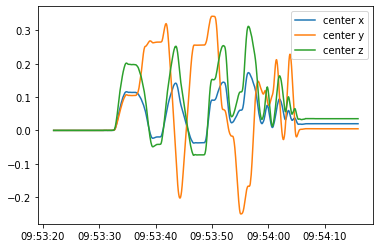

In [188]:
plt.plot(mc["time"], mc["cen_x"], label="center x")
plt.plot(mc["time"], mc["cen_y"], label="center y")
plt.plot(mc["time"], mc["cen_z"], label="center z")
plt.legend()

In [189]:
"""resetting cart values to zero"""
cart_df["e_fr"] = cart_df["e_fr"]- cart_df["e_fr"].iloc[0]
cart_df["e_fl"] = cart_df["e_fl"]- cart_df["e_fl"].iloc[0]
cart_df["e_rr"] = cart_df["e_rr"]- cart_df["e_rr"].iloc[0]
cart_df["e_rl"] = cart_df["e_rl"]- cart_df["e_rl"].iloc[0]

cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl,rtc,mils,sync,time
607,2022-06-23 09:53:21.983740,0,0,0,0,2019-01-01 05.31.27.000000 AM,88258,1,2022-06-23 09:53:21.904
608,2022-06-23 09:53:21.984242,0,0,0,0,2019-01-01 05.31.27.000000 AM,88268,1,2022-06-23 09:53:21.914
609,2022-06-23 09:53:21.984764,0,0,0,0,2019-01-01 05.31.27.000000 AM,88278,1,2022-06-23 09:53:21.924
610,2022-06-23 09:53:21.985264,0,0,0,0,2019-01-01 05.31.27.000000 AM,88288,1,2022-06-23 09:53:21.934
611,2022-06-23 09:53:22.054762,0,0,0,0,2019-01-01 05.31.27.000000 AM,88298,1,2022-06-23 09:53:21.944
...,...,...,...,...,...,...,...,...,...
5408,2022-06-23 09:54:10.017709,-1453,251,-331,-1808,2019-01-01 05.32.15.000000 AM,136301,1,2022-06-23 09:54:09.947
5409,2022-06-23 09:54:10.018210,-1453,251,-331,-1808,2019-01-01 05.32.16.000000 AM,136311,1,2022-06-23 09:54:09.957
5410,2022-06-23 09:54:10.018712,-1453,251,-331,-1808,2019-01-01 05.32.16.000000 AM,136321,1,2022-06-23 09:54:09.967
5411,2022-06-23 09:54:10.018712,-1453,251,-331,-1808,2019-01-01 05.32.16.000000 AM,136331,1,2022-06-23 09:54:09.977


In [190]:
mils = np.arange(0, len(cart_df["e_fr"])*10, 10)
cart_df["mils"] = mils
cart_df["sys_time"] = pd.to_datetime(cart_df["sys_time"])

These are the parameters of the cart

Diameter = 95 mm
radius = 47.5
wheel thickness = 45 mm
gap between wheel and chassis = 6.5 mm
angle between center of chassis and z-dir vector = 51.21 degrees
distance between the wheel = 158 mm
distance between the wheel and the center of the robot = 101.36 (li)


In [191]:
"""circumfrence of the wheel"""

cir_wheel = np.degrees(2*np.pi*(47.5/1000))
cir_wheel
radius = 47.5/1000

lx = 79 #half of the distance between the wheels
ly = 122.5/2

lx = lx/1000
ly = ly/1000

The encoder values will give 4000 values per revolution
360/4000 = 0.09 degrees per encoder rotation value

In [192]:
""" angular velocity"""
cart_df["av_fr"] = (cart_df["e_fr"]*0.09).diff()/0.01
cart_df["av_fl"] = (cart_df["e_fl"]*0.09).diff()/0.01
cart_df["av_rr"] = (cart_df["e_rr"]*0.09).diff()/0.01
cart_df["av_rl"] = (cart_df["e_rl"]*0.09).diff()/0.01
cart_df['av_fr'] = cart_df["av_fr"].fillna(0)
cart_df['av_fl'] = cart_df["av_fl"].fillna(0)
cart_df['av_rr'] = cart_df["av_rr"].fillna(0)
cart_df['av_rl'] = cart_df["av_rl"].fillna(0)

#converting them to radians
cart_df['av_fr'] = cart_df["av_fr"]* np.pi/180
cart_df['av_fl'] = cart_df["av_fl"]* np.pi/180
cart_df['av_rr'] = cart_df["av_rr"]* np.pi/180
cart_df['av_rl'] = cart_df["av_rl"]* np.pi/180

cart_df["av_fl"]

607     0.0
608     0.0
609     0.0
610     0.0
611     0.0
       ... 
5408    0.0
5409    0.0
5410    0.0
5411    0.0
5412    0.0
Name: av_fl, Length: 4806, dtype: float64

In [210]:
# g1 = np.radians(-51.21)
# g2 = np.radians(51.21)

b1 = -np.radians(np.pi/2)
b2 = np.radians(np.pi/2)
b3 = b2
b4 = b1


g1 = np.pi/4
g2 = -np.pi/4
g3 = g1
g4 = g2


# a1 = np.pi/4
# a2 = -np.pi/4
# a3 = 3*np.pi/4
# a4 = -3*np.pi/4

a1 = np.radians(51.21)
a2 = -np.radians(51.21)
a3 = np.radians(51.21+90)
a4 = -np.radians(51.21+90)


li = 101.36/1000

In [211]:
t = (-1/radius)*np.array([[np.cos(b1 - g1)/ np.sin(g1), np.sin(b1 - g1)/np.sin(g1), li * np.sin(b1 - g1 - a1)/np.sin(g1)],
                         [np.cos(b2 - g2)/ np.sin(g2), np.sin(b2 - g2)/np.sin(g2), li * np.sin(b2 - g2 - a2)/np.sin(g2)],
                         [np.cos(b3 - g3)/ np.sin(g3), np.sin(b3 - g3)/np.sin(g3), li * np.sin(b3 - g3 - a3)/np.sin(g3)],
                         [np.cos(b4 - g4)/ np.sin(g4), np.sin(b4 - g4)/np.sin(g4), li * np.sin(b4 - g4 - a4)/np.sin(g4)]]
                         )
t
pseudo_t = np.linalg.pinv(t)
pseudo_t

array([[-0.01154502,  0.01154502, -0.01219606,  0.01219606],
       [ 0.00183587,  0.00183587,  0.02248943,  0.02248943],
       [ 0.15394828,  0.15394828, -0.16262961, -0.16262961]])

In [212]:
val = pseudo_t @ np.array([[cart_df["av_fr"].iloc[0]],[cart_df["av_fl"].iloc[0]], [cart_df["av_rr"].iloc[0]], [cart_df["av_rl"].iloc[0]]])
val.T

array([[0., 0., 0.]])

In [213]:
cart_df["av_fr"].iloc[0]

0.0

In [214]:
np.array([[cart_df["av_fr"].iloc[0]],[cart_df["av_fl"].iloc[0]], [cart_df["av_rr"].iloc[0]], [cart_df["av_rl"].iloc[0]]])

array([[0.],
       [0.],
       [0.],
       [0.]])

In [215]:
_val = []
for i in range(len(cart_df["e_fl"])):
    _v = pseudo_t @ np.array([[cart_df["av_fr"].iloc[i]],[cart_df["av_fl"].iloc[i]], [cart_df["av_rr"].iloc[i]], [cart_df["av_rl"].iloc[i]]])
    _val.append(_v.T[0])

cart_df[["cal_vx", "cal_vy", "cal_w"]] = _val
# _val

In [216]:
"""finding vx, vy, w"""

cart_df["vx"] = (cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] + cart_df["av_rr"])*(radius/4)
cart_df["vy"] = (- cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] - cart_df["av_rr"])*(radius/4)
cart_df["w"] = (- cart_df["av_fl"] + cart_df["av_fr"] - cart_df["av_rl"] + cart_df["av_rr"])*(radius/(4*(lx + ly)))

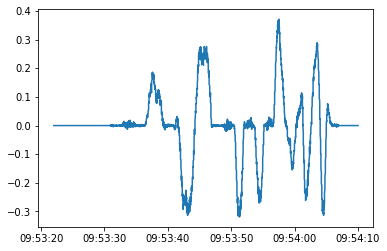

In [217]:
plt.plot(cart_df["sys_time"], cart_df["vy"])
# plt.plot(cart_df["vx"])

In [218]:
"""calculating displacement
s=(1/2)* (v+u)t
v = current velocityn
u = initial velocity
t = time
s = displacement
"""

_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["vx"].iloc[i] + cart_df["vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["vy"].iloc[i] + cart_df["vy"].iloc[i-1])*0.01
        # print(y_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+y_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["x_val"] = _xval
cart_df["y_val"] = _yval
# cart_df["y_val"]

In [219]:
"""calculating displacement for calculated coordinates

"""
_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["cal_vx"].iloc[i] + cart_df["cal_vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["cal_vy"].iloc[i] + cart_df["cal_vy"].iloc[i-1])*0.01
        # print(x_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+y_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["cal_x"] = _xval
cart_df["cal_y"] = _yval


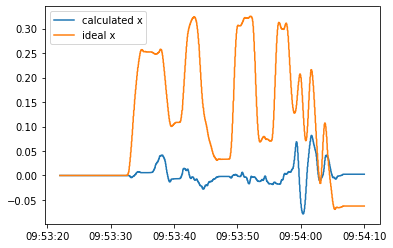

In [220]:
# plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "ideal x")
plt.plot(cart_df["sys_time"],cart_df["cal_x"], label = "calculated x")
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "ideal x")
plt.legend()

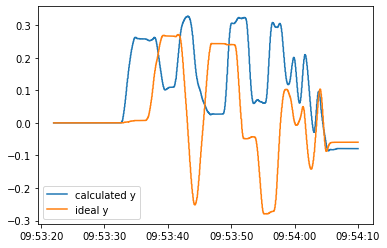

In [221]:
plt.plot(cart_df["sys_time"],cart_df["cal_y"], label = "calculated y")
plt.plot(cart_df["sys_time"], cart_df["y_val"], label = "ideal y")
plt.legend()

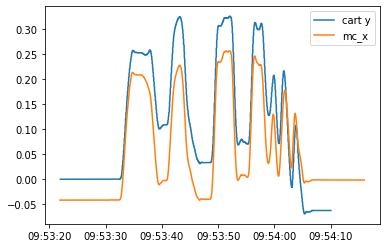

In [205]:
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "cart y")
plt.plot(mc["time"], mc["org_z"], label  = "mc_x")
plt.legend()

In [206]:
_t2 = []
for i in cart_df["sys_time"]:
    _tt = mc["time"][0]-i
    # print(_tt)
    _t2.append(_tt.total_seconds())


-0.055481


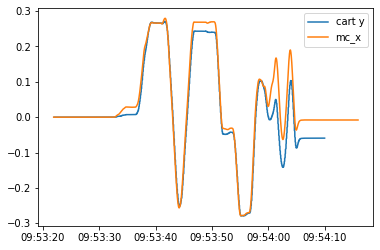

In [207]:
offset = cart_df["y_val"].iloc[0] - mc["org_x"].iloc[0]
plt.plot(cart_df["sys_time"], cart_df["y_val"], label = "cart y")
plt.plot(mc["time"], mc["org_x"] +offset, label  = "mc_x")
plt.savefig("lateral.png")
plt.legend()
print(offset)

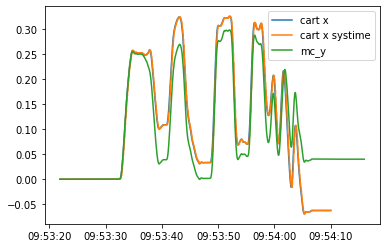

In [225]:
offset = cart_df["x_val"].iloc[0] - mc["org_z"].iloc[0]
plt.plot(cart_df["time"], cart_df["x_val"], label = "cart x")
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "cart x systime")
plt.plot(mc["time"], mc["org_z"] +offset, label  = "mc_y")
# 

plt.legend()
plt.savefig("transversal.png")

In [209]:
# print (cart_df["sys_time"].get_loc(mc["time"][0], method='nearest'))
print(cart_df["time"].iloc[0])
print(mc["time"].iloc[0])

result_index = cart_df['sys_time'].sub(mc["time"].iloc[0]).abs().idxmin()

cart_df.iloc[(cart_df['sys_time'] - mc["time"].iloc[0]).abs().argsort()[0],:]
# (cart_df['sys_time'] - mc["time"][0]).abs()
result_index

2022-06-23 09:53:21.904000
2022-06-23 09:53:21.904000


KeyError: 0

In [ ]:
# cart_df["diff"] = cart_df["y_val"]- cart_df["center_x"] - 0.34

In [ ]:
rw = []
vr = []
for i in range(len(cart_df["av_rl"])):
    _vy = cart_df["cal_vy"].iloc[i]
    _vx = cart_df["cal_vx"].iloc[i]
    rw.append(np.arctan2(_vy, _vx))
    vr.append(np.linalg.norm((_vx, _vy)))
cart_df["rw"] = rw
cart_df["vr"] = vr

In [ ]:
cart_df["rw"]

431     0.0
432     0.0
433     0.0
434     0.0
435     0.0
       ... 
2492    0.0
2493    0.0
2494    0.0
2495    0.0
2496    0.0
Name: rw, Length: 2066, dtype: float64

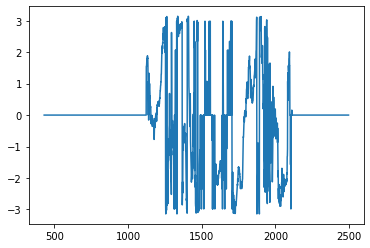

In [ ]:
plt.plot(cart_df["rw"])

In [ ]:
cart_df["rw"]

431     0.0
432     0.0
433     0.0
434     0.0
435     0.0
       ... 
2492    0.0
2493    0.0
2494    0.0
2495    0.0
2496    0.0
Name: rw, Length: 2066, dtype: float64